# Paper implementation challenge - Quantum Compression Algorithm for Symmetric States

This notebook is part of the paper implementation challenge, where we implement the algorithm described in the paper [[1](#Compression_Algorithm_Paper)] by Martin Plesch and Vladimír Bužek. The paper presents a method for efficiently constructing a quantum circuit that compresses multiple copies of identical quantum states into a lower-dimensional Hilbert space. This compression can be generalized not only to identical states but to any quantum state that is symmetric under permutation of the qubits.

## Mathematical formulation
Any identical quantum state can be written as $\left|\psi\right\rangle^{\otimes n} = \underset{k=0}{\overset{n}{\sum}}\alpha^{n-k}\beta^{k}\sqrt{\binom{n}{k}}\left|n;k\right\rangle
     = A_k\left|n;k\right\rangle$, where the $\left|n;k\right\rangle = \sqrt{\binom{n}{k}}^{-1} \sum_{\sigma} \sigma \left (\left|1\right\rangle^{\otimes k} \otimes \left|0\right\rangle^{\otimes (n-k)}\right)$, $\sigma$ representing all the permutations given the specific number of qubits in $\left|0\right\rangle$ and $\left|1\right\rangle$. 

The circuit presented in the original paper transforms each $\left|n;k\right\rangle$ into a new state $\left|C_k\right\rangle$, which corresponds to a state having only 1 excitation $\left(\left|C_k\right\rangle = \left|0\right\rangle^{\otimes{k-1}}\otimes \left|1\right\rangle \otimes \left|0\right\rangle^{\otimes(n-k)}\right)$. So, the goal is to construct a circuit that will perform this kind of operation, i.e. $U(\left|n;k\right\rangle) = \left|C_k\right\rangle$. After constructing the $\left|C_k\right\rangle$ states, we need to complete the compression algorithm by performing the last part - the transformation of each $\left|C_k\right\rangle$ into $\left|B_k\right\rangle$, which represent a binary encoded state.


## Circuit analysis
We have provided in the following image an example of how to construct the $U$ gate for a circuit composed of 5 qubits, as presented in the paper. The $U$ gate is composed of two sub-gates, called $U_{ab}$ and $U_{f}$, which will be described below. Each of these two sub-gates needs to be applied multiple times, as specified in the paper. The gate $V$ at the beginning is a combination of two-qubit gates and is applied only once.

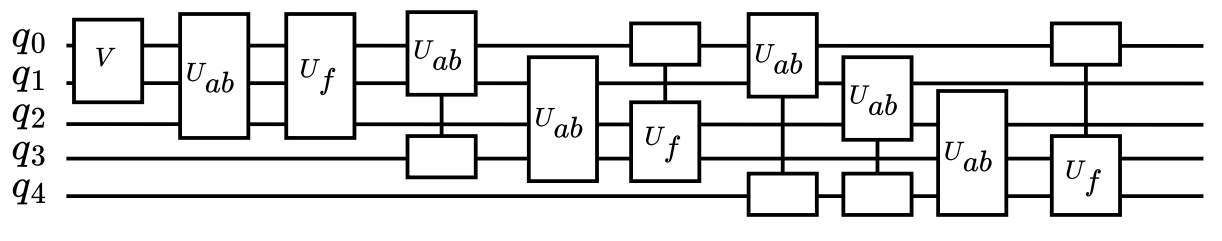

For multiple qubits, the number of sub-gates increases, causing the circuit depth to grow quadratically. In the paper, only the number of CNOT gates used is analyzed. To construct the behavior of the $U$ gate, a total of $\frac{21}{2}\left({n^2 - n - 2}\right) + 3$ CNOT gates are required, where $n$ is the number of qubits in the circuit.

For the last component of the algorithm, the upper bound on the number of CNOT gates that need to be applied is given in the paper as $n\log_2^2\left(n\right)$.


## The functionality of $U$ gate
After applying a two qubits gate composed of a CNOT and a CH ($V$, which will be presented) on the first two qubits, we define these two qubits as belonging to the transformed section of the quantum state. All remaining qubits are considered part of the non-transformed section.

We will proceed with the transformation to gradually enlarge the transformed part of the state. To do this, we will take the first qubit (let us denote this qubit as the $a^{th}$ qubit) of the non-transformed part of the state. We will perform specific three qubit operations on this qubit and any neighboring pair of qubits in the transformed part of the state. This operations will perform following actions:

1. If the ath qubit is in the state $\left|0\right\rangle$, no change needs to be done to the transformed part of the state, as the excitation is on the proper position also including the ath qubit into the transformed part of the state.
2. If the ath qubit is in the state $\left|1\right\rangle$, the sequence of operations will ”scan” the transformed state and shift the excitation by one position to the right and remove the excitation from the ath qubit.
3. Specifically, if the ath qubit is in the state $\left|1\right\rangle$ and there was no excitation so far in the transformed part of the state, the operation will switch the first
qubit to the state $\left|1\right\rangle$ and remove the excitation from the ath qubit at the same time.
4. Specifically, if the ath qubit is in the state $\left|1\right\rangle$ and the excitation in the transformed part of the string is on the last position (qubit a − 1), the operation will remove this excitation, but will keep the excitation on the ath qubit.


## The functionality of the last component of the algorithm
The final step of the algorithm will be to transform each of the state $\left|C_k\right\rangle$ into a new state so that in total just a number of $\log_2(n+1)$ qubits will be used. This component of the algorithm will transform $\left|C_k\right\rangle$ (one-hot encoded state) into $\left|B_k\right\rangle$ (binary encoded state). More detail on this can be seen at [[2](#Encodings)]. 




The operation is reversible, so that the decompression could be performed.



## Solving with the Classiq Platform

In [1]:
from math import sqrt

import numpy as np
from scipy.special import comb

from classiq import *
from classiq.qmod.symbolic import pi

### Defining the classical functions that are necessary for constructing the U gate

#### The first part of the $U$ : $U_{ab}$
We are defining the function that is creating the gate $U_{ab}$. This is part of the gate U from the paper and represents
a three qubit gate that is constructed based on values b, b + 1 and a. This is the first operation of gate U and needs to have the following behaviour.


$
\begin{aligned}
&|00\rangle_b |0\rangle_a \longrightarrow |00\rangle_b |0\rangle_a \\
&|10\rangle_b |0\rangle_a \longrightarrow |10\rangle_b |0\rangle_a \\
&|00\rangle_b |1\rangle_a \longrightarrow |00\rangle_b |1\rangle_a \\
&|01\rangle_b |1\rangle_a \longrightarrow |01\rangle_b |1\rangle_a \\
&\alpha_{101} |10\rangle_b |1\rangle_a + \alpha_{010} |01\rangle_b |0\rangle_a 
\longrightarrow \beta_{010} |01\rangle_b |0\rangle_a,
\end{aligned}
$

where
$\alpha_{101} = \sqrt{\binom{a-1}{b}}, \qquad 
\alpha_{010} = \sqrt{\binom{a-1}{b+1}}, \qquad 
\beta_{010} = \sqrt{\binom{a}{b+1}}.$




In [2]:
def U_ab(a, b):
    """
    Construct the unitary operator U_ab as described in the paper.
    Arguments:
        a: integer value representing the index of qubit a
        b: integer value representing the index of qubit b
    """

    U = np.eye(8, dtype=complex)

    # Compute coefficients as illustrated in the paper
    alpha_101 = np.sqrt(comb(a - 1, b, exact=True))
    alpha_010 = np.sqrt(comb(a - 1, b + 1, exact=True))
    beta_010 = np.sqrt(comb(a, b + 1, exact=True))

    x = alpha_010 / beta_010
    y = alpha_101 / beta_010

    # Performing the superposition swap as presented in the paper.
    i_rot, j_rot = (2, 5)
    U[i_rot, i_rot] = x
    U[i_rot, j_rot] = y
    U[j_rot, i_rot] = y
    U[j_rot, j_rot] = -x

    return U

#### The second part of the $U$ : $U_{f}$
We are Defining the function that is creating the gate $U_{f}$. This is part of the gate U from the paper and represents a three qubit gate that is constructed based on values 0, a-1 and a. This is the second operation of gate U and needs to have the following behaviour.
$
\begin{aligned}
&|0\rangle_1 |00\rangle_{a-1} \longrightarrow |0\rangle_1 |00\rangle_{a-1} \\
&|0\rangle_1 |10\rangle_{a-1} \longrightarrow |0\rangle_1 |10\rangle_{a-1} \\
&|0\rangle_1 |11\rangle_{a-1} \longrightarrow |0\rangle_1 |01\rangle_{a-1} \\
&\alpha_{001} |0\rangle_1 |01\rangle_{a-1} + \alpha_{100} |1\rangle_1 |00\rangle_{a-1}
\longrightarrow \beta_{100} |1\rangle_1 |00\rangle_{a-1},
\end{aligned}
$

where
$
\alpha_{001} = 1; \qquad \alpha_{100} = \sqrt{a - 1}; \qquad \beta_{100} = \sqrt{a}.
$


In [3]:
def U_f(a):
    """
    Constructs the unitary operator U_f as described in the paper.
    Arguments:
        a: integer value representing the index of qubit a.
    """

    # Compute coefficients as illustrated in the paper
    alpha_001 = 1
    alpha_100 = sqrt((a - 1))
    beta_100 = sqrt(a)

    x = alpha_100 / beta_100
    y = alpha_001 / beta_100

    # Performing the superposition swap as presented in the paper.
    U = np.eye(8, dtype=complex)
    i_rot, j_rot = (1, 4)
    U[i_rot, i_rot] = x
    U[i_rot, j_rot] = y
    U[j_rot, i_rot] = -y
    U[j_rot, j_rot] = x

    return U

### Defining the quantum functions that are necessary for constructing the algorithm

#### Constructing a general multi-CNOT gate that is going to be needed in tha last part of the algorithm
This function has the role of creating and applying a multi-controlled NOT operation given a set of qubit indeces. The controls list contains the list of the qubits that needs to be the controll qubits and the last element in the list represents the target element.


In [4]:
from functools import reduce


@qfunc
def apply_MultiCNOT(q: QArray, controls: list[int]):
    """
    Apply a multi-controlled NOT gate to a set of qubits.
    Arguments:
        q: the QArray of qubits to which the gate will be applied.
        controls: the control qubits for the multi-controlled NOT gate. The last qubit in the list is the target qubit.
    The other qubits are the control qubits.
    """

    # constructing a temporary QArray of qubits representing the specific qubits in q given by the indexes in controls
    control(
        reduce(lambda x, y: x & y, [q[i] for i in controls[:-1]]),
        lambda: X(q[controls[-1]]),
    )

#### Constructing the wrapper for the $U_{ab}$ gate that is going to be applied in the circuit
This function is a wrapper of the function U_ab and has the purpose of applying the gate for as many times as needed as it is ilustrated in the paper. U_ab needs to be applied for every qubit b from 1 to a-2.


In [5]:
@qfunc
def apply_U_ab(a: int, q: QArray):
    """
    Arguments:
        a: integer value representing the index of qubit a.
        q: the QArray of qubits to which the operator will be applied.
    """
    for b in range(a - 1):
        Uab = U_ab(a + 1, b + 1)
        unitary(Uab, [q[b], q[b + 1], q[a]])

#### Constructing the wrapper for the $U_{f}$ gate that is going to be applied in the circuit
This function is a wrapper of the function U_f and has the purpose of applying the gate 1 time as stated in paper. The gate is going to be applied on qubits 0, a-1 and a.



In [6]:
@qfunc
def apply_U_f(a: int, q: QArray):
    """
    Arguments:
        a: integer value representing the index of qubit a.
        q: the QArray of qubits to which the operator will be applied.
    """
    Uf = U_f(a + 1)
    unitary(Uf, [q[0], q[a - 1], q[a]])

#### Constructing the wrapper for the $U$ gate that is going to be applied in the circuit
This function is a wrapper and has the purpose of applying the gate U on the qubits given as input.

In [7]:
@qfunc
def apply_U(q: QArray):
    """
    Arguments:
        q: the QArray of qubits to which the gates will be applied.
    """

    # Applying the U gates as in paper. This sequence will construct the |C>_k bases for the symmetric states.
    for i in range(2, q.len):
        apply_U_ab(i, q)
        apply_U_f(i, q)

        # The last CNOT is the personal addition because the description in the paper is not quite exact on the
        # implentation part. They are just describing what the functions should do.
        control(q[i], lambda: X(q[i - 1]))

#### Constructing the wrapper for the last component of the algorithm
This function encapsulates the conversion from the one-hot encoding into binary encoding so that the last component of the algorithm is performed. 

In [8]:
@qfunc
def onehot_to_binary_encode(q: QArray) -> None:
    """
    Convert the one-hot encoding of the qubits to binary encoding.
    Apply the last sequence described in paper for converting the |C>_k into |B>_k.
    Arguments:
        q: the QArray of qubits to be converted.
    """

    for k in range(2, q.len):
        indices = []
        bin_size = len(bin(k + 1)[2:])
        for i in range(bin_size):
            if bin(k + 1)[2:][i] == "1":

                control(q[k], lambda: X(q[bin_size - i - 1]))

                indices.append(bin_size - i - 1)
        indices = indices[::-1]

        indices.append(k)  # last qubit is the target qubit
        apply_MultiCNOT(q, indices)

#### Constructing the wrapper for the whole algorithm
This function contains the core logic of the compression algorithm as presented in the paper. It takes as input a QArray representing the qubits to which the algorithm will be applied.

In [9]:
@qfunc
def symmetric_compression_algorithm(q_array: QArray):
    """
    The main function that implements the symmetric compression algorithm as described in the paper.
    Arguments:
        q_array: the QArray of qubits to be compressed.
    """

    # Implementing the V gate from the paper
    control(q_array[1], lambda: X(q_array[0]))
    control(q_array[0], lambda: H(q_array[1]))

    # Applying the U gates as in paper. This sequence will construct the |C>_k bases for the symmetric states
    apply_U(q_array)

    # Applying the last sequence described in paper for converting the |C>_k into |B>_k
    onehot_to_binary_encode(q_array)

### Testing the algorithm

#### Test 1 - Compressing a quantum state of 5 identical qubits prepared in $\left|+\right\rangle$

In [10]:
@qfunc
def main(x: Output[QArray]):
    allocate(5, x)
    hadamard_transform(x)
    symmetric_compression_algorithm(x)


model1 = create_model(main)
write_qmod(
    model1,
    "quantum_compression_algorithm_for_symmetric_states",
    decimal_precision=8,
    symbolic_only=False,
)
quantum_program1 = synthesize(model1)
job1 = execute(quantum_program1)
results1 = job1.result()[0].value.parsed_counts
show(quantum_program1)
results1

Quantum program link: https://platform.classiq.io/circuit/2zDu80orsRMqOBEWEvQOIeATR4X


[{'x': [0, 1, 0, 0, 0]}: 651,
 {'x': [1, 1, 0, 0, 0]}: 648,
 {'x': [0, 0, 1, 0, 0]}: 326,
 {'x': [1, 0, 0, 0, 0]}: 296,
 {'x': [0, 0, 0, 0, 0]}: 66,
 {'x': [1, 0, 1, 0, 0]}: 61]

As we can see, the compression of the initial state worked, as the last two qubits are no longer used, being in state $\left|0\right\rangle$ for all of the possible states. This proves that the reduction worked, thus one being able to represent a 5 qubit state using just 3 qubits.

#### Test 2 - Compressing a quantum state of 3 qubits prepared in $W_3$ state

In [11]:
@qfunc
def main(x: Output[QArray]):
    amplitude = [0, 1 / 3, 1 / 3, 0, 1 / 3, 0, 0, 0]
    prepare_amplitudes(amplitude, 0, x)
    symmetric_compression_algorithm(x)


model2 = create_model(main)
quantum_program2 = synthesize(model2)
job2 = execute(quantum_program2)
results2 = job2.result()[0].value.parsed_counts
show(quantum_program2)
results2

Quantum program link: https://platform.classiq.io/circuit/2zDu9LsmNpk3KgFgSIdeojCxgfL


[{'x': [1, 0, 0]}: 2048]

As we can see, the compression worked, allowing us to represent the $W_3$ state using just one qubit. This opens up the possibility of using the compression algorithm in an entanglement distribution scheme, as the single qubit can be teleported using the standard quantum teleportation protocol. Also, we can see that the algorithm works for symmetric states, and not just identical ones.

#### Test 3 - Compressing a non symmetric quantum state

In [12]:
@qfunc
def main(x: Output[QArray]):
    allocate(3, x)
    hadamard_transform(x)
    Y(x[0])
    symmetric_compression_algorithm(x)


model3 = create_model(main)
quantum_program3 = synthesize(model3)
job3 = execute(quantum_program3)
results3 = job3.result()[0].value.parsed_counts
show(quantum_program3)
results3

Quantum program link: https://platform.classiq.io/circuit/2zDuAYaE7cU9mXsXoaNsvKvznCW


[{'x': [1, 1, 1]}: 544,
 {'x': [0, 1, 1]}: 509,
 {'x': [1, 1, 0]}: 260,
 {'x': [0, 0, 0]}: 228,
 {'x': [0, 0, 1]}: 179,
 {'x': [1, 0, 1]}: 179,
 {'x': [0, 1, 0]}: 88,
 {'x': [1, 0, 0]}: 61]

We can see that in the case of a non-symmetric initial state, the algorithm does not perform any compression, thus confirming the hypothesis.

## References

<a id='Compression_Algorithm_Paper'>[1]</a>: [Efficient compression of quantum information](https://arxiv.org/pdf/0907.1764)

<a id='Encodings'>[2]</a>: [Encoding Conversions](https://docs.classiq.io/latest/explore/algorithms/dqi/dqi_max_xorsat/#step-2-encoding-conversions)


